In [1]:
import numpy as np
import scipy as sp
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import time
import os
import sys
import pickle

from minibatch import *

physical_devices = tf.config.experimental.list_physical_devices('GPU') 
for physical_device in physical_devices: 
    tf.config.experimental.set_memory_growth(physical_device, True)

Using TensorFlow backend.


In [2]:
!pwd

/home/sweet/2-coursework/725bmes/eeg_deeplearning/neural_network/src


In [3]:
IS_RUNNING_PAIRWISE = False
IS_SAVE_TRAINING_HISTORY = False
GEN_PICKLE_INPUT_TARGET = False

# Define sliding window

In [4]:
from numpy.lib.stride_tricks import as_strided

def sliding_window(a, w = 4, o = 2, copy = False):
    sh = (a.size - w + 1, w)
    st = a.strides * 2
    view = np.lib.stride_tricks.as_strided(a, strides = st, shape = sh)[0::o]
    if copy:
        return view.copy()
    else:
        return view

In [5]:
def genAllDat(db, b, targetClas, nClas=7, nTrials=200, nWin=1, S=16, nX=9, nY=9):
    
    inputs = np.zeros((nWin*nTrials*nClas, S, nX, nY))
    targets = np.zeros(nWin*nTrials*nClas, dtype=int)
    wins = np.zeros(nWin*nTrials*nClas, dtype=int)

    seq_perms = create_rand_seq_permutations(db)
    k = 0
    for trial in range(0,nTrials):
        for clas in targetClas:
            perm = seq_perms[clas][trial]
            tmp = db[clas][perm]

            for win in range(0,nWin):
                inputs[k] = tmp[b[win,:]]
                targets[k] = clas
                wins[k] = win
                k=k+1
    return inputs, targets, wins

# Load Data

In [6]:
db_dir = "/home/sweet/2-coursework/725bmes/eeg_deeplearning/data_extraction/src/"
ME_db_fname = "mesh_ME_db_128.pickle"
ME_db = {}

t1 = time.time()
with open(db_dir + "/" + ME_db_fname, "rb") as f:
    ME_db_2Dmesh = pickle.load(f)
print("Loaded ME database in %f s" % (time.time()-t1))

Loaded ME database in 1.840039 s


In [7]:
# Create folder for model's checkpoints
pwd = os.getcwd()
ckt_pt_dir = pwd + "/check_points"
try:
    if not os.path.isdir(ckt_pt_dir):
        os.mkdir(ckt_pt_dir)
except OSError as error:
    print("Cannot create directory. Exiting...")
    print(error)

# Define Neural Network

In [8]:
S = 8    # S = number of images
K = 7    # K = number of classes
last_fc = 64
dropout_rate = 0.5
opt = keras.optimizers.Adam(learning_rate=1e-4)
lossfn = 'categorical_crossentropy'
metric = ['acurracy']

In [9]:
def get_compiled_casc_model(S, K=8, last_fc=64, dropout_rate=0.5, 
                            activation_last='softmax', opt=keras.optimizers.Adam(learning_rate=1e-4), 
                            loss='categorical_crossentropy'):
    model = models.Sequential()
    model.add(layers.Input(shape=(S, 9, 9, 1)))
    model.add(layers.TimeDistributed(layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')))
    model.add(layers.TimeDistributed(layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')))
    model.add(layers.TimeDistributed(layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')))
    model.add(layers.TimeDistributed(layers.Flatten()))
    model.add(layers.TimeDistributed(layers.Dense(1024, activation='relu')))
    model.add(layers.TimeDistributed(layers.Dropout(dropout_rate)))
    model.add(layers.LSTM(S, return_sequences=True))
    model.add(layers.LSTM(S))
    model.add(layers.Dense(last_fc, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(K, activation=activation_last))
    model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])

    return model

In [10]:
def create_batches(X, Y, batch_size=64):
    i = 0
    while True:
        yield X[i:i+batch_size], Y[i:i+batch_size]
        i = i + batch_size

In [11]:
classes = [1,5]
nClas = len(ME_db_2Dmesh)
nTrials = ME_db_2Dmesh[1].shape[0]
nFrames = ME_db_2Dmesh[1].shape[1]
nX = ME_db_2Dmesh[1].shape[2]
nY = ME_db_2Dmesh[1].shape[3]
display(ME_db_2Dmesh[1].shape)

(741, 257, 9, 9)

In [12]:
batch_size = 64
n_epochs = 20

In [13]:
if IS_RUNNING_PAIRWISE:
    accuracy_pairwise = np.zeros((7,7))
    for c1 in range(1,7):
        for c2 in range(c1+1,8):
            classes = [c1, c2]
            print('Training on class', classes)
            a = np.arange(nFrames)
            b = sliding_window(a, S, S//2)

            nWin = b.shape[0]
            inputs, targets, wins = genAllDat(ME_db_2Dmesh, b, classes, len(classes), nTrials, nWin, S, nX, nY)
            # shuffle the dataset
            inputs, targets = shuffle(inputs, targets)
            inputs = np.expand_dims(inputs, axis=-1)

            where_are_NaNs = np.isnan(inputs)
            inputs[where_are_NaNs] = 0

            # restructure to go up starting from 1
            j = 1
            for i in classes:
                targets[:] = [x if x != i else j for x in targets]
                j = j+1

            # split into training and testing set
            X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.2)

            y_train = to_categorical(y_train-1)
            y_test = to_categorical(y_test-1)
            
            # define early stopping
            outputFile = output_dir_Pairwise+"/CascadeModel_S"+str(S)+"_C"+str(c1)+"_"+str(c2)+"_"+"Epochs"+str(nEpochs)+".h5"
            checkpoint = ModelCheckpoint(outputFile, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
            early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1, mode='auto')

            model = get_compiled_casc_model(S, K=2, activation_last='sigmoid', loss='binary_crossentropy')
            t1 = time.time()
            model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose=1, 
                      validation_split=0.2, callbacks=[checkpoint, early])
            print('Training on class', classes, ' finished in ', str(time.time() - t1), 's')

            print('Evaluate on class', classes)

            # evaluate model
            _, accuracy = model.evaluate(X_test, y_test, verbose=1)

            accuracy_pairwise[c1-1,c2-1] = accuracy

In [14]:
if IS_RUNNING_PAIRWISE:
    accuracy_pairwise= accuracy_pairwise+np.transpose(accuracy_pairwise)

    plt.figure(figsize = (7,7))
    plt.imshow(accuracy_pairwise, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.show()

In [15]:
classes = [1, 2, 3, 4, 5, 6, 7]
n_epochs = 50
print('Training on class', classes)
a = np.arange(nFrames)
b = sliding_window(a, S, S//2)

nWin = b.shape[0]
inputs, targets, wins = genAllDat(ME_db_2Dmesh, b, classes, len(classes), nTrials, nWin, S, nX, nY)
# shuffle the dataset
inputs, targets = shuffle(inputs, targets)
inputs = np.expand_dims(inputs, axis=-1)

# where_are_NaNs = np.isnan(inputs)
# inputs[where_are_NaNs] = 0

# restructure to go up starting from 1
j = 1
for i in classes:
    targets[:] = [x if x != i else j for x in targets]
    j = j+1

# split into training and testing set
X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.2)

y_train = to_categorical(y_train-1)
y_test = to_categorical(y_test-1)

Training on class [1, 2, 3, 4, 5, 6, 7]


In [16]:
checkpoint = ModelCheckpoint("CascadeModel_S8_C1to7_Epochs50_test.h5", monitor='val_accuracy', verbose=0, 
                             save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1, mode='auto')

model = get_compiled_casc_model(S, K=7)
model.save('CascadeModel_S8_C1to7_init.h5')
t1 = time.time()
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, 
                    verbose=1, validation_split=0.2, callbacks=[checkpoint,early])
print('Training on class', classes, ' finished in ', str(time.time() - t1), 's')

print('Evaluate on class', classes)

# evaluate model
_, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)

print(accuracy)

Epoch 1/50
3268/3268 [==============================] - 71s 22ms/step - loss: 1.9350 - accuracy: 0.1644 - val_loss: 1.9078 - val_accuracy: 0.1972
Epoch 2/50
3268/3268 [==============================] - 71s 22ms/step - loss: 1.8813 - accuracy: 0.2147 - val_loss: 1.8318 - val_accuracy: 0.2579
Epoch 3/50
3268/3268 [==============================] - 71s 22ms/step - loss: 1.7799 - accuracy: 0.2869 - val_loss: 1.7100 - val_accuracy: 0.3249
Epoch 4/50
3268/3268 [==============================] - 71s 22ms/step - loss: 1.6148 - accuracy: 0.3722 - val_loss: 1.5681 - val_accuracy: 0.3918
Epoch 5/50
3268/3268 [==============================] - 71s 22ms/step - loss: 1.4040 - accuracy: 0.4656 - val_loss: 1.4205 - val_accuracy: 0.4540
Epoch 6/50
3268/3268 [==============================] - 71s 22ms/step - loss: 1.1865 - accuracy: 0.5532 - val_loss: 1.2847 - val_accuracy: 0.5142
Epoch 7/50
3268/3268 [==============================] - 71s 22ms/step - loss: 0.9925 - accuracy: 0.6268 - val_loss: 1.2029 -

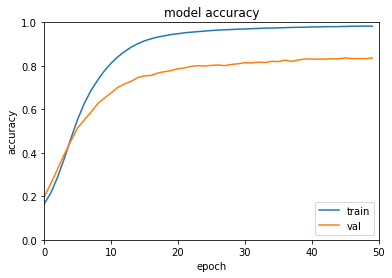

In [21]:
# summarize history for accuracy
f = plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.xlim((0, 50))
plt.ylim((0, 1))
plt.show()

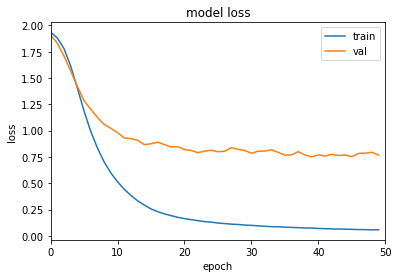

In [22]:
# summarize history for loss
f = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.xlim((0, 50))
plt.show()

In [23]:
if IS_SAVE_TRAINING_HISTORY:
    # save the fitting history to a file
    with open(output_dir+"CascadeModel_train_history.pickle", 'wb') as f:
        pickle.dump(history.history, f)

In [24]:
if GEN_PICKLE_INPUT_TARGET:
    outputFile = ["inputs_S"+str(S)+"_C1to7.pickle", \
              "targets_S"+str(S)+"_C1to7.pickle", \
              "wins_S"+str(S)+"_C1to7.pickle"]

    dat = [inputs, targets, wins]

    t1 = time.time()
    for i in range(0,3):
        f = open(output_dir+outputFile[i], "wb")
        i_str = pickle.dumps(dat[i])
        f_size = sys.getsizeof(i_str)
        f.write(i_str)
        f.close()
        print("Finished writing %.2f MB of data to %s in %f s" % (f_size, outputFile[i], time.time()-t1))